<a href="https://colab.research.google.com/github/LiyaUnknown/Simple_Gan/blob/main/prj3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# tensorflow - Deep Convolutional Generative Adversarial Network

In [ ]:
import numpy as np
import tensorflow as tf
import PIL
import os
import matplotlib.pyplot as plt
import time 
import glob
from IPython import display

In [ ]:
(tr_ , trl_ ) , (_ , _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
images = tr_.reshape((tr_.shape[0] , 28 , 28 , 1)).astype('float32')
images = (tr_ - 127.5) / 127.5 
img_dt = tf.data.Dataset.from_tensor_slices(images).shuffle(60000).batch(256)

In [ ]:
images[0].shape

(28, 28)

1/1 [==============================] - 10s 10s/step


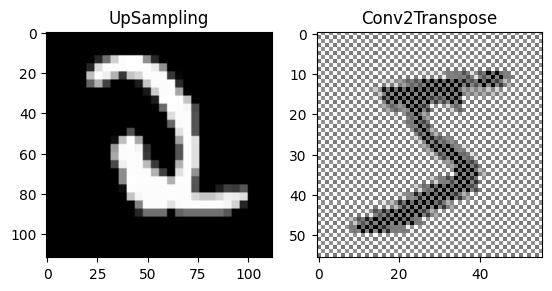

In [ ]:
img_1 = images[400].reshape((1 , 28 , 28 , 1))

model_1 = tf.keras.Sequential()
conv_1 = model_1.add(tf.keras.layers.UpSampling2D((4,4)))

pre = model_1.predict(img_1)

model_2 = tf.keras.Sequential()
conv_2 = model_2.add(tf.keras.layers.Conv2DTranspose(1, (2, 2), strides=(2, 2) , input_shape = (28,28,1) ))

plt.subplot(1,2,1)
plt.imshow(pre.reshape((4 * 28,4 * 28 , 1)) , cmap = 'gray')
plt.title('UpSampling')

plt.subplot(1,2,2)
pre = model_2.predict(images[0].reshape((1 , 28 , 28 , 1)))
plt.imshow(pre.reshape((2 * 28,2 * 28 , 1)) , cmap = 'gray')
plt.title('Conv2Transpose')

plt.show()

In [ ]:
from keras.layers.attention.multi_head_attention import activation
from tensorflow.keras.layers import Dense , Conv2DTranspose , LeakyReLU , BatchNormalization , Reshape

def mk_gen() : 

    model = tf.keras.Sequential()
    model.add(Dense(7*7*256 , use_bias = False , input_shape = (100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7 , 7 , 256)))
    assert model.output_shape == (None , 7 , 7 , 256)

    model.add(Conv2DTranspose(128 , (5,5) , strides = (1,1) , padding = 'same' , use_bias = False))
    assert model.output_shape == (None , 7 , 7 , 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64 , (5,5) , strides = (2,2) , padding = 'same' , use_bias = False))
    assert model.output_shape == (None , 14 , 14 , 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1 , (5,5) , strides = (2,2) , padding = 'same' , use_bias = False , activation = 'tanh'))
    assert model.output_shape == (None , 28 , 28 , 1)


    return model



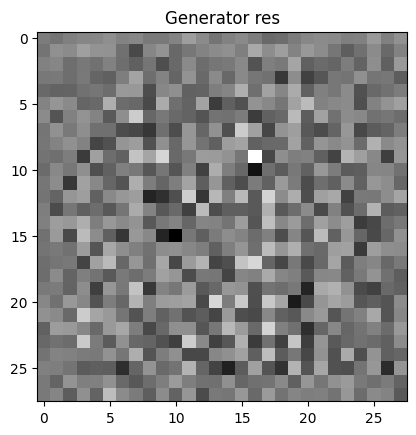

In [ ]:
fake_dt = tf.random.normal([1,100])
generator = mk_gen()
imgo = generator(fake_dt , training = False)

plt.imshow(imgo[0 , : , :  , 0] , cmap = 'gray')
plt.title('Generator res')

plt.show()

In [ ]:

from keras.layers.reshaping.flatten import Flatten
from keras.layers import Dropout
from tensorflow.keras.layers import Dense , Conv2DTranspose , LeakyReLU , BatchNormalization , Reshape , Conv2D

def mk_dis() :

    model = tf.keras.Sequential([
        Conv2D(64 , (5,5) , (2 , 2) , input_shape = [28 , 28 , 1] , padding = 'same') ,
        LeakyReLU() , 
        Dropout(0.3) , 

        Conv2D(128 , (5,5) , (2 , 2) , padding = 'same') ,
        LeakyReLU() , 
        Dropout(0.3) , 

        Flatten() , 
        Dense(1) 
        
    ])

    return model


In [ ]:
discriminator = mk_dis()


for i in img_dt : 
    res = discriminator(i , training = True)
    print(total_losses(res , fake_dt))

res = discriminator(imgo)
print(res)

In [ ]:
cros_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(n) :
    return cros_entropy(tf.ones_like(n) , n)

def total_losses(x , n) : 
    return cros_entropy(tf.ones_like(x) , x) + cros_entropy(tf.zeros_like(n) , n)


In [ ]:
gen_op = tf.keras.optimizers.Adam(0.0001)
dis_op = tf.keras.optimizers.Adam(0.0001)

In [ ]:


chkp_d = '/content/chkp_dir'
prefix = os.path.join(chkp_d , 'points')
check_p = tf.train.Checkpoint(generator_optimizer=gen_op,
                                 discriminator_optimizer=dis_op,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
generator(tf.random.normal([256 , 100])).shape

TensorShape([256, 28, 28, 1])

In [ ]:
tf.function
def train_step(imges) : 
    print(imges.shape)
    noise = tf.random.normal([256 , 100]) 
    with tf.GradientTape() as g , tf.GradientTape() as d : 
          
          gen_lo = generator_loss(discriminator(generator(noise , training = True) , training = True ))
          dis_lo = total_losses(discriminator(imges , training = True) , discriminator(generator(noise , training = True) , training = True ))

    gen_gr = g.gradient(gen_lo , generator.trainable_variables)
    dis_gr = d.gradient(dis_lo , discriminator.trainable_variables)

    gen_op.apply_gradients(zip(gen_gr , generator.trainable_variables))
    dis_op.apply_gradients(zip(dis_gr , discriminator.trainable_variables))


In [ ]:
def save_gen_img(model , epoch , random_noise) :

    img_ = model(random_noise , training = False)

    plt.figure(figsize = (4 , 4))

    for i in range(random_noise.shape[0]) :
        plt.subplot(4 , 4 , i + 1)

        plt.imshow(img_[i , : , : , 0] * 127.5 + 127.5 , cmap = 'gray')
        plt.axis('off')

    plt.savefig(f'generation_image_epoch: {epoch}')
    plt.show()

In [ ]:
epochs = 50
number_of_img = 16
random_noises_imgs = tf.random.normal([number_of_img , 100])

def fit(data_st , epochs ) :
    for epoch in range(1 , epochs) : 
        for im in data_st : 
            train_step(im)

        display.clear_output(wait=True)
        save_gen_img(generator , epoch+1 , random_noises_imgs)
        if (epoch + 1) % 15 == 0 : 
            check_p.save(prefix)
        print(f'This model is in epoch {epoch} as {epochs}')
    display.clear_output(wait=True)
    save_gen_img(generator , epoch+1 , random_noises_imgs)
fit(img_dt , epochs)

In [ ]:
fit(img_dt , epochs)